In [9]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [10]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [11]:
dataset = 'movielens'  #bibx,biby,movielens
full_X,y,test_mask = helper_func.load_data(dataset)
y = full_X
result_folder = "dual_bibtex"
metric = 'mae_nz_all'
tot = 100
tot += 1
ndcg = []
test_every = 20;
no_sample = 100
score = []

In [12]:
K = 50
users = y.shape[0]
items = y.shape[1]
param = models.hpf(users,items)
a = a_c = c = c_c = 0.3
b_c = d_c = 1.0      

In [15]:
kappa_shp =  np.random.uniform(low=0.1,size=(users,1))*(a_c + K*a)
kappa_rte = np.random.uniform(low=0.1,size=(users,1))
tau_shp = np.random.uniform(low=0.1,size=(items,1))*(c_c + K*c)
tau_rte = np.random.uniform(low=0.1,size=(items,1))
phi = np.zeros([users,items,K])
gam_shp = np.random.uniform(low=0.1,size=[users,K])
gam_rte = np.random.uniform(low=0.1,size=[users,K])
lam_shp = np.random.uniform(low=0.1,size=[items,K])
lam_rte = np.random.uniform(low=0.1,size=[items,K])
non_zero_indices = helper_func.non_zero_entries(y)    

In [16]:
for ite in range(0,tot):

    print(ite)
    varphi_u = (sp.digamma(gam_shp)-np.log(gam_rte)).reshape((1,users,K)).repeat(items,axis=0).swapaxes(0,1)
    varphi_i = (sp.digamma(lam_shp)-np.log(lam_rte)).reshape((1,items,K)).repeat(users,axis=0)
    varphi = varphi_u + varphi_i
    log_norm = logsumexp(varphi,axis=2)
    varphi = np.exp(varphi-log_norm[:,:,np.newaxis])
    temp = y[:,:,np.newaxis]*varphi
    gam_shp = a + temp.sum(axis=1)
    gam_rte = (kappa_shp/kappa_rte).repeat(K,axis=1) + ((lam_shp/lam_rte).sum(axis=0,keepdims=True)).repeat(users,axis=0)
    kappa_rte = a_c/b_c + (gam_shp/gam_rte).sum(axis=1,keepdims=True)
    lam_shp = c + temp.sum(axis=0)
    lam_rte = (tau_shp/tau_rte).repeat(K,axis=1) +((gam_shp/gam_rte).sum(axis=0,keepdims=True)).repeat(items,axis=0)
    tau_rte = c_c/d_c + (lam_shp/lam_rte).sum(axis=1,keepdims=True)

    if ite%test_every == 0:
        q_theta = Gamma(gam_shp,gam_rte)
        q_beta = Gamma(np.transpose(lam_shp),np.transpose(lam_rte))
        beta_sample = q_beta.sample(no_sample).eval()
        theta_sample = q_theta.sample(no_sample).eval()
        score.append(helper_func.check(param,theta_sample,beta_sample,test_mask,full_X,metric=metric))
        gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


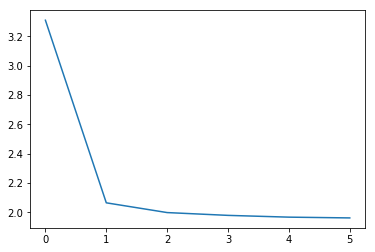

1.96307169022


In [17]:
plt.plot(score)
plt.show()
print min(score)